In [119]:
import random

In [120]:
class Board:
    def __init__(self, board = '---------', turn = 'X'):
        self.turn = turn
        self.board_list = list(board)
        # board states are a 9-character representing the state of the board.

    def reset(self):
        self.turn = 'X'
        self.board_list = list('---------')
        
    def show(self):
        state = self.board_list
        print(state[0],'|', state[1],'|', state[2], sep='')
        print('-----')
        print(state[3],'|', state[4],'|', state[5], sep='')
        print('-----')
        print(state[6],'|', state[7],'|', state[8], sep='')
    
    def move(self, index):
        self.board_list[index] = self.turn
        self.turn = 'X' if self.turn == 'O' else 'O' # switch turn
    
    def winner(self):
        straight_lines = ((0,1,2),(3,4,5),(6,7,8),(0,3,6),
                          (1,4,7),(2,5,8),(0,4,8),(2,4,6))
        for turn in ['X','O']:
            for line in straight_lines:
                if all(x == turn for x in (self.board_list[i] for i in line)):
                    return turn
        return '' # if there is no winner

    def is_full(self):
        return('-' not in self.board_list)

In [121]:
class Player:
    def __init__(self, policy = 'random'):
        self.policy = policy  #'random, max'
        self.alpha = 0.5
        self.gamma = 1
        self.V = {} # if it always start as O player, we don't need separate value functions
        self.old_move = None # used for updating
    
    def state_value(self, board_string):
        if board_string not in self.V:
            return 0
        else:
            return self.V[board_string]

    def select_move(self, board):
        open_indices = [ind for ind, val in enumerate(board.board_list) if val == '-']        
        if self.policy == 'random':
            move_ind = random.choice(open_indices)
        else: # self.policy == 'max'
            future_boards = []
            for i in open_indices:
                after_move_board = board.board_list.copy()
                after_move_board[i] = board.turn
                future_boards.append(''.join(after_move_board))
            future_values = [self.state_value(x) for x in future_boards]
            
            #old way: pick the first value that is the max
            #move_ind = future_values.index(max(future_values)) # pick the largest value
            
            #better way: randomly pick one of the maximum values
            max_val = max(future_values) # will often be 0 in the beginning
            max_pos = [i for i, j in enumerate(future_values) if j == max_val]
            max_indices = [open_indices[x] for x in max_pos]
            move_ind = random.choice(max_indices)
        return move_ind
        
    def move(self, board):
        move_ind = self.select_move(board)
        
        board.move(move_ind)
            
        #updating move history
        self.current_move = ''.join(board.board_list)
        self.reward(0, game_over = False)
        
        self.old_move = self.current_move # now that the move is over
        
        
    def reward(self, reward_value, game_over = True):
        (OM,V) = (self.old_move, self.V) #shorten later statements 

        if not OM: # if it's just the first move
            return
        
        if game_over:
            current_state_value = 0
        else:
            current_state_value = self.state_value(self.current_move)

        if OM not in V:
            V[OM] = 0
        
        V[OM] += self.alpha * (reward_value + self.gamma * current_state_value - V[OM])

In [122]:
class Tournament:
    def __init__(self, playerA, playerB):
        self.playerA = playerA
        self.playerB = playerB
        self.history = []
        self.board = Board()
    
    def reset(self):
        self.history = []
    
    def play_game(self):
        self.board.reset()
        if (random.random() < 0.5):  # randomly pick the player to start
            current_player = self.playerA
        else:
            current_player = self.playerB
        while (not self.board.is_full() and not self.board.winner() ):
            if (current_player == self.playerA): # switch players
                current_player = self.playerB
            else:
                current_player = self.playerA
            current_player.move(self.board)
        if self.board.winner():
            if current_player == self.playerA:
                self.history.append('A')
                self.playerA.reward(100, game_over = True)
                self.playerB.reward(-100, game_over = True)
            else: # player B won
                self.history.append('B')
                self.playerA.reward(-100, game_over = True)
                self.playerB.reward(100, game_over = True)
        else: # it was a tie
            self.history.append('-')
            self.playerA.reward(0, game_over = True)
            self.playerB.reward(0, game_over = True)
    
    def play_games(self, games_to_play):
        for i in range(games_to_play):
            self.play_game()
        print(self.history[-games_to_play:].count('A'),'games won by player A')
        print(self.history[-games_to_play:].count('B'),'games won by player B')
        print(self.history[-games_to_play:].count('-'),'ties')

In [132]:
A = Player('max')
B = Player('max')
tournament = Tournament(A,B)
tournament.play_games(100)
print()
tournament.play_games(100000)
print()
tournament.play_games(100)

48 games won by player A
41 games won by player B
11 ties

61 games won by player A
71 games won by player B
99868 ties

0 games won by player A
0 games won by player B
100 ties


In [133]:
# observe a few board state value functions
print(A.state_value('-O--X----'))
print(A.state_value('X--------'))
print(A.state_value('XXX-O-O--'))

0.0
0.0
0


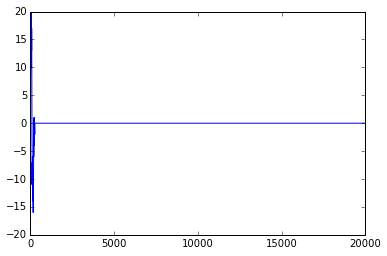

In [134]:
# plot the history
import numpy as np
import pylab as py
import matplotlib
%matplotlib inline 

history = np.array(tournament.history.copy())
rewards = np.zeros(len(history))
rewards[history == 'A'] = 100
rewards[history == 'B'] = -100

N = 100
def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]
r_mean = running_mean(rewards, 100)
py.plot(r_mean[0:20000])